# Modely pro predikci šíření Coronaviru a nemoci COVID-19 v různých zemích

Tomáš Kulhánek<sup>1,2</sup>, Jiří Kofránek<sup>1,2</sup>

<sup>1</sup>Oddělení biokybernetiky a počítačové podpory výuky, ÚPF, 1.LFUK <sup>2</sup>Creative Connections,s.r.o. 

Tento notebook není oficiální zdroj informací, používá data z věřejných zdrojů. Zdrojové kódy ke stažení na https://github.com/creative-connections/Bodylight-notebooks/tree/master/Covid-19. Pokud najdete nějakou chybu, tak ji reportujte, buď jako github issue, PR, nebo můžete kontaktovat autory (tmkulhanek at gmail.com) anebo (kofranek at gmail.com). Tento notebook je stále ve vývoji a je/bude updatován příštích několik týdnů (březen 2020).

Obsahuje porovnání tzv. logistického modelu a exponenciálního modelu, které se používají pro predikci šíření jakékoliv nákazy. Příklady data a predikce jsou provedeny pro šíření nákazy Coronavirem a infekce nemoci COVID-19 ve světě a v Česku. Data jsou získávána z věřejných zdrojů - viz Reference dole. Pro výpočty používáme skripty v jazyku Python a knihovny pro podporu datové vědy.

Tento notebook (zápisník) je interaktivní, s textovými buňkami a buňkami s kódem, který je možné editovat a pustit s jinými parametry. Je možné se v něm pohybovat šipkami nahoru a dolů. Pro vykonání kódu v buňkách stiskněte `Shift-Enter`. Obsah buněk je editovatelný, v tom případě po změně kódu můžete pustit skript znovu pomocí `Shift-Enter`.

Nejprve importujeme knihovny

In [27]:
# First we import related python libs used further
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
# matplotlib widget needs latest ipympl, e.g.: conda install -c conda-forge ipympl
#%matplotlib widget
# figx=9; figy=5
%matplotlib inline
figx=14;figy=7;

Nyní definujeme rutiny pro stažení dat, cache dat a úpravu dat dle různých formátů do tabulky pandas v prvním sloupci den, v druhém sloupci počet nakažených.

In [2]:
#cache data
#26.3.2020 update - slight change in data format 
# see more https://github.com/pcm-dpc/COVID-19
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dfi = pd.read_csv(url)
#data from Italian national agency, seems to be updated in daily basis
def getdatafromItaly():
    global dfi
    df = dfi
    df = df.loc[:,['data','totale_casi']]
    FMT = '%Y-%m-%dT%H:%M:%S'
    date = df['data']
    df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days  )
    return df

In [3]:
# cache data
# 26.3.2020 - updated link to RAW data - WHO changed data format - reflected in CSSE data set 
# see https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
dfw = pd.read_csv(url)
def getdatafromWHO(country,addlastdaynum=0,region=np.nan):
    global dfw
    df3 = dfw
    #select country,region
    dfcz = df3.loc[(df3['Country/Region']==country) & (pd.isna(df3['Province/State'])),:] if (pd.isna(region)) else dfw.loc[(df3['Country/Region']==country) & (df3['Province/State']==region),:]

    #dfcz = df3.loc[df3['Country/Region']==country,:] if (pd.isna(region)) else df3.loc[(df3['Country/Region']==country) & (df3['Province/State']==region),:]
    #select only data relevant of coronavirus COVID-19, strip country name, location,... 
    dfcz2 = dfcz.iloc[:,4:]
    #strip columns where infected is 0
    dfcz21 = dfcz2.loc[:, (dfcz2 != 0).any(axis=0)]
    dfcz22 = dfcz21.rename(index={dfcz21.first_valid_index():"infected"},errors="raise")
    #transpose
    dfcz3 = dfcz22.transpose()
    #calculate number of days from 1.1.2020 based on date in first column
    d = (datetime.strptime(dfcz21.columns[0], "%m/%d/%y")-datetime(2020,1,1)).days
    #insert just day numbers 
    dfcz3.insert(0,'days',range(d,int(d+len(dfcz3.index))))
    #optionally append one number with most updated data - 13.3. number 113
    if (addlastdaynum>0):
        dfcz33 = dfcz3.append({"days":d+len(dfcz3.index),"infected":addlastdaynum},ignore_index=True)
        return dfcz33
    return dfcz3
    #print(dfcz33,df2)
    

In [58]:
urlcz = "https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakaza.csv"
dfczmzcr = pd.read_csv(urlcz)
def getdatafromCzechia():
    # TODO CSV resource not found yet, manually updated every day, https://onemocneni-aktualne.mzcr.cz/covid-19
    #crdata=[['days','infected'],[61,3],[62,3],[63,5],[64,5],[65,8],[66,19],[67,26],[68,32],[69,38],[70,63],
    #        [71,94],[72,116],[73,141],[74,189],[75,298],[76,383],[77,436],[78,560],[79,765],[80,889],[81,1047],
    #        [82,1161],[83,1287],[84,1472],[85,1763],[86,2022],[87,2395]]
    #df2 = pd.DataFrame(crdata[1:],columns=crdata[0])
    global dfczmzcr
    dfcz21 = dfczmzcr.loc[:,['datum','pocet_celkem']]
    FMT = '%Y-%m-%d'
    date = dfcz21['datum']
    dfcz21['datum'] = date.map(lambda x : ((datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days+1 ) )
    dfcz22 = dfcz21[dfcz21['pocet_celkem']>0]
    return dfcz22

# 1. Logistický model
Logistický model se používá např. pro zkoumání výskytu onemocnění a šíření v populaci. Více viz https://en.wikipedia.org/wiki/Logistic_regression

$$ f(x,a,b,c)= \frac{c}{1+e^\frac{-(x-b)}{a} } $$

* $x$ čas
* $a$ rychlost šíření infekce. Parametr a se v průběhu epidemie mění podle různých opatření, které autority vyhlašují a  lidé je víceméně dodržují, např. změní své chování, izolovanost. Nicméně pro tento model se parametr odhaduje jako jedno "průměrné číslo".
* $b$ kritický bod, den kdy se nakazilo nejvíce lidí. Tento parametr se může odhadnout podle data, kdy se vyhlásila opatření pro izolaci lidí a se odhadem spoždění (např. průměrná inkubační doba). Pro každou zemi je tak nutno analyzovat tisk či jiné zdroje informací, ze kterých je možné odvodit, kdy došlo k plošnému omezení styku lidí, nebo k jiným opatřením - plošné testování a individuální karanténa. Numerický odhad parametru b (dále uváděn v optimistický model) může vést ke zkresleným odhadům až o několik řádů.
* $c$ celkový počet nakažených lidí - tento parametr odhaduje celkový počet nakažených, tj. ti kteří si nakazili, jsou stále nakažení, nebo se vyléčili, nebo zemřeli. Skutečná promořenost v populaci bude pravděpodobně větší, neboť záleží, jak plošně se testuje celá populace.



In [5]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



## 1.1 Exponenciální model
Exponenciální model vystihuje dobře šíření nákazy na počátku epidemie nebo v průběhu nekontrolovatelného šíření. Je dobrým ukazatelem pro porovnání s dalšími modely a s reálnými daty.

$$ f(x,a,b,c)= a.e^{b(x-c)} $$

In [26]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

 ## 1.2 Odhad parametrů modelu podle dat
 
Modely mají parametry, hodnoty parametrů lze odhadnout tak, že hodnoty predikované modelem se co nejvíce blíží reálným datům. Používají se různé metody jako proložení křivky, metoda nejmenších čtverců atd. V následujícím použijeme metodu `curve_fit`  z knihovny `scipy`, která používá právě metodu nejmenších čtverců a proloží křivku přes reálná data. 

In [7]:
def getxy(dfcz33):
    x = list(dfcz33.iloc[:,0])
    y = list(dfcz33.iloc[:,1])
    return (x,y)

def fitlogisticmodel(x,y):
    #fit data to logistic model
    fit=[[4,75,100000]]
#    try:
        #fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],method='lm')#,bounds=([0.5,30,15][10,120,10e+7]))
        #fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],method='lm',maxfev=5000)#,bounds=([0.5,30,15][10,120,10e+7]))
    fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],maxfev=5000,bounds=([0.5,30,300],[10,120,7e+6]))
#    except:
#        print('fit not found, attemp 0');
#        for i in range(1,5):
#            try:
#                fit = curve_fit(logistic_model,x,y,p0=[i,70,i*1000**(i/3)],bounds=([0.5,60,15][10,120,1e+7]),maxfev=5000)
#                break;
#            except:
#                print('fit not found, attemp ',i);
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

def fitlogisticmodel_b(x,y,fixb):
    #fit data to logistic model with already estimated parameter B 
    fit = curve_fit(logistic_model,x,y,p0=[2,fixb,20000],bounds=[[1,fixb,150],[10,fixb+1,10e+6]])
    
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

In [8]:
def fitexponentialmodel(x,y):
    #fit data to exponential model
    exp_fit = curve_fit(exponential_model,x,y,p0=[0.02,0.1,2.8])
    return exp_fit


## 1.3 Vizualizace výsledků predikce modelů a reálných dat

Nyní definujeme rutiny pro vizualizaci výsledků predikce jednotlivých modelů s reálnými daty.

In [9]:
# converts number of array of numbers (days from 1st January 2020) 
# into appropriate datetime object or array of datetime objects
def xtodate(x):
    from datetime import date,timedelta
    from collections.abc import Iterable
    
    FirstJan = date(2020,1,1)
    if isinstance(x, Iterable):
        xdate = []
        for xx in x:
            xdate.append(FirstJan + timedelta(xx))
        return xdate;    
    else:
        return FirstJan + timedelta(x)


In [37]:
#single chart with real data,exponential and logistic curve 
def plotchart(x,y,lastday,fit,exp_fit,errors):
    global figx,figy;
    pred_x = list(range(max(x),lastday))
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [figx, figy]
    plt.rc('font', size=10)
    # Real data
    plt.scatter(xtodate(x),y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(xtodate(x+pred_x), [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
    # Predicted exponential curve
    plt.plot(xtodate(x+pred_x), [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='b', linestyle='dotted')
    plt.text(xtodate(lastday-2),fit[0][2]*1.02,int(fit[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.legend()    
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,fit[0][2]*1.1))
    #fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

#single charts with real data,exponential and 2 logistic curves
def plotcharts(x,y,lastday,fit,exp_fit,errors,lastday2,fit2,exp_fit2,errors2):
    global figx,figy;
    pred_x = list(range(max(x),lastday))
    pred_x2 = list(range(max(x),lastday2))
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [figx, figy]
    plt.rc('font', size=10)
    # Real data
    plt.scatter(xtodate(x),y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(xtodate(x+pred_x), [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
    plt.plot(xtodate(x+pred_x2), [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Logistic model b=85" )
    # Predicted exponential curve
    plt.plot(xtodate(x+pred_x), [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='g', linestyle='dotted')
    plt.text(xtodate(lastday-2),fit[0][2]*1.02,int(fit[0][2]))
    plt.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    plt.text(xtodate(lastday2-10),fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    plt.legend()
    fig.autofmt_xdate()
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1))    
    plt.grid(True)
    plt.show()

#double charts, one with normal scale, second with logarithmic scale
def plotcharts_norm_vs_log(x,y,lastday,fit,exp_fit,errors,lastday2,fit2,exp_fit2,errors2):
    global figx,figy;
    pred_x = list(range(max(x),lastday))
    pred_x2 = list(range(max(x),lastday2))

    plt.rcParams['figure.figsize'] = [figx, figy]
    plt.rc('font', size=8)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Real data
    ax1.scatter(xtodate(x),y,label="Real data",color="red")
    # Predicted logistic curve
    ax1.plot(xtodate(x+pred_x), [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model b="+str(int(fit[0][1])))
    ax1.plot(xtodate(x+pred_x2), [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Logistic model b="+str(int(fit2[0][1]))) 
    # Predicted exponential curve
    ax1.plot(xtodate(x+pred_x), [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    ax1.axhline(y=fit[0][2], color='g', linestyle='dotted')
    ax1.text(xtodate(lastday-2),fit[0][2]*1.02,int(fit[0][2]))
    ax1.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    ax1.text(xtodate(lastday2-2),fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    ax1.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    ax1.legend()
    ax1.set(ylabel="Total number of infected people",
            ylim=(min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1))  
    ax1.grid(True)
    fig.autofmt_xdate()
    # Real data
    ax2.scatter(xtodate(x),y,label="Real data",color="red")
    # Predicted logistic curve
    ax2.plot(xtodate(x+pred_x), [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model b="+str(int(fit[0][1])))
    ax2.plot(xtodate(x+pred_x2), [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Logistic model b="+str(int(fit2[0][1])))
    # Predicted exponential curve
    ax2.plot(xtodate(x+pred_x), [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    ax2.axhline(y=fit[0][2], color='g', linestyle='dotted')
    ax2.text(xtodate(lastday-2),fit[0][2]*1.02,int(fit[0][2]))
    ax2.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    ax2.text(xtodate(lastday2-10),fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    ax2.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    ax2.legend()
    print('min y',min(y))
    ax2.set(ylabel="Total number of infected people, log scale",
            ylim=(min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1),    
            yscale="log")
    ax2.grid(True)    
    plt.show()
    

## 1.4 Analýza dat

Nyní můžeme už definovat sekvenci volání funkcí pro analýzu dat.

In [36]:
def analyze_data(df,estb=0):
    (x,y) = getxy(df)
    #try to fit all parameters a,b,c    
    (fit,lastday,errors) = fitlogisticmodel(x,y)
    #try to fit parameters a,c, 
    #estimate b (critical point) as e.g. 7-14 days after 
    #quarantine and other actions were introduced in population
    fit_exp = fitexponentialmodel(x,y)
    date_lastday=datetime(2020,1,1) + timedelta(days=lastday)    
    if estb>0:
        (fit2,lastday2,errors2) = fitlogisticmodel_b(x,y,estb)
        plotcharts_norm_vs_log(x,y,lastday,fit,fit_exp,errors,lastday2,fit2,fit_exp,errors2)
    else:
        plotchart(x,y,lastday,fit,fit_exp,errors)
    return (date_lastday,fit,errors)
    
def analyze_for_country(country,addlastnum=0,estb=0,region=np.nan):
    # get data from WHO
    
    df = getdatafromWHO(country,addlastnum) if (pd.isna(region)) else getdatafromWHO(country,addlastnum,region)
        
    (date_lastday,fit,errors) = analyze_data(df,estb)
    #print('Model of COVID-19 infection in',country,'based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')

def analyze_czechia(estb=0):    
    df = getdatafromCzechia()
    (date_lastday,fit,errors) = analyze_data(df,estb)
    #print('Model of COVID-19 infection in Czechia based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')


# Česko

Data jsou dostupná ze zdrojů [3] a [2]. Data se mírně liší, podle metodiky hlášení a potvrzení. Protože je epidemie v pokročilém stádiu a byla přijata opatření, lze odhadnout parametr 'b' logistického modelu. Predikce se ze dne na den už neliší řádově. Stále je nutné porovnávat logistický model s exponenciálním modelem, který vystihuje dobře šíření na začátku epidemie.

Parameters of logistic model fit a: 4.502792728999537  b: 87.04874244127748  c: 5124.929230986883  errors of c: 549.1201328435982
Parameters of logistic model fit a: 4.257239765654909  b: 85.99999999999999  c: 4543.414412792602  errors of c: 407.332411815768


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


min y 3


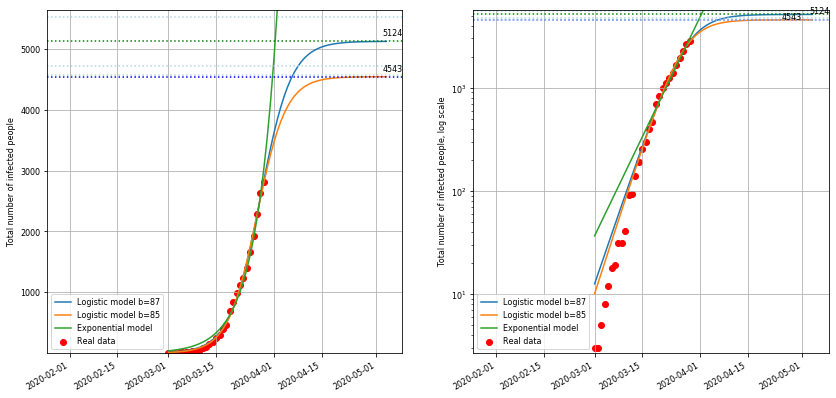

In [59]:
analyze_for_country('Czechia',estb=85) #update 14:18, 13.3.2020 total number of cases reported 120 - being updated manually


Parameters of logistic model fit a: 4.481765496434785  b: 87.09121589874168  c: 4708.4752953532725  errors of c: 402.5872651415722
Parameters of logistic model fit a: 4.197042035224419  b: 85.99999999999999  c: 4174.466916759109  errors of c: 299.87482189696897


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


min y 3


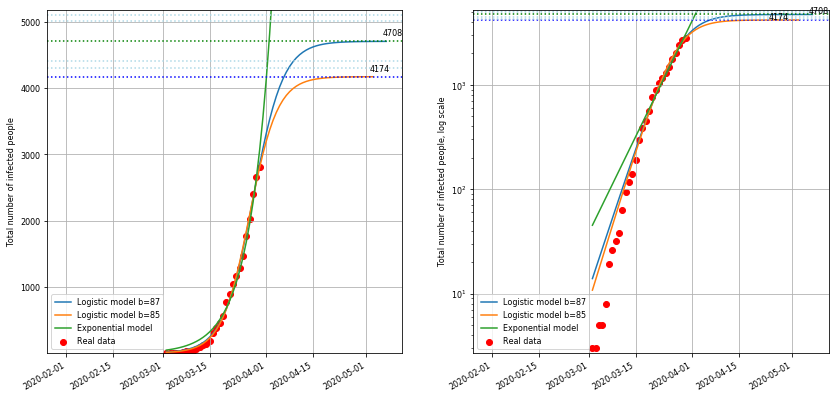

In [60]:
analyze_czechia(estb=85)

## Shrnutí pro Česko
Modely jsou citlivé na vstupní data, data z WHO obsahují verifikované pozitivní testy[3], data z českých zdrojů bereme ze sady celkových (neverifikovaných) testů [2], toto číslo se může mírně lišit. Predikce se shodnou v řádu (1518 vs 966). Každý den nicméně počet potvrzených nakažených roste. Z reálných dat plyne, že se ještě nedosáhlo kritického bodu b, proto odhady modelů se každý den zvyšují. Přidali jsme proto odhad parametru b na den 85 - tj. 25.3.2020 (viz Realistic logistic model), kdy by mohl být největší nárůst zaznamenaných nakažených - odhadnuto jako 12 dní (7-14 dnů je inkubační doba nemoci) po vyhlášení opatřeních vládou z 13.3.2020.

* 16.3. Uvidíme jak realistický odhad modelu bude odpovídat zpřesňujícím se datum v budoucnu (psáno 16.3.2020)
* 24.3. Realistický model z českých dat predikuje 3592(+-1235) nakažených. Z reálných dat vypadá, že se dosáhlo bodu b, tj. maximální denní nárust počtu nakažených je/byl mezi 80-85 dnem (20-25 březnem). Nicméně tato data mohou být zkreslena počtem a způsobem testování. Optimistický model odhaduje rychlost šíření infekce parametr a=2.93.  
* 27.3. Realistický model predikuje 3536 nakažených. Stále je ve hře exponenciální růst, V příštích dnech se ukáže, jestli reálná data ukáží stále exponenciální trend nebo už klesající trend podle logistického modelu. 
* 30.3. ÚZIS nyní publikuje aktualizované datové sady v CSV, není nutné aktualizovat ručně. Vypadá, že bodu zlomu 'b' odhaduje `curve_fit` více než odhadovaný 25.3.2020 tj. den 85. Numerický odhad nyní je na 87. tj 27.3.2020. Nárůst se už dva dny snižuje. Predikce 4708(+-402) nakažených

# Model a predikce pro Jižní Koreu

Parameters of logistic model fit a: 3.5550546921057764  b: 61.4335881929976  c: 8837.86246384349  errors of c: 65.73213680975277
Parameters of logistic model fit a: 4.29877892256192  b: 63.00000000000001  c: 9289.610966881379  errors of c: 117.17563162839171


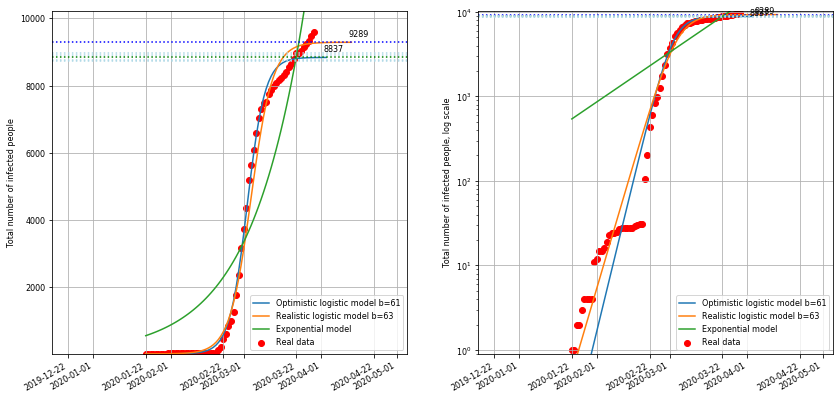

In [14]:
analyze_for_country('Korea, South',estb=63)

## Shrnutí pro Jižní Koreu
Z reálných dat plyne, že v Koreji se již dosáhlo bodu b a proto predikce modelu se již každým dnem výrazně už nemění.
* 13.3. predikce 7982 (+- 38 ). 
* 16.3. predikce 8097 (+-32). A chování modelů více odpovídá Logistické křivce než exponenciálnímu modelu. Lze i s opatrností interpretovat, že v Jižní Koreji mají šíření nemoci COVID-19 pod kontrolou.
* 24.3. predikce optimistického modelu 8482 je pod skutečným počtem zaznamenaných případů. Od dne 70, je stále konstantní nárůst nových nakažených, podle zpráv jde pravděpodobně o občany vracející se ze zahraničí, jež jsou plošně testovány, z Evropy všichni povinně, nyní se zvažuje rozšířit povinnost pro cestovatele z USA (zdroj https://www.koreatimes.co.kr/www/nation/2020/03/119_286739.html)


# Čína, provincie Chupej (angl. přepis Hubei)

Parameters of logistic model fit a: 4.260527100478921  b: 39.693922712515544  c: 67740.30840348455  errors of c: 331.1179534799696


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


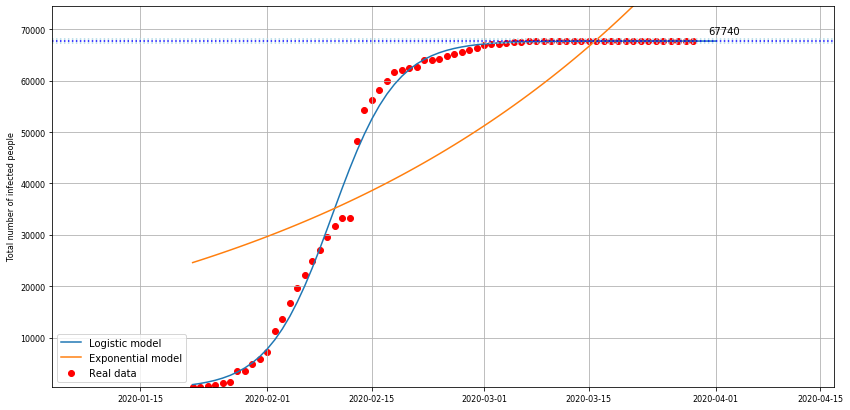

In [15]:
analyze_for_country('China',region='Hubei')

## Shrnutí
* Proč používáme logistický model pro predikci šíření coronaviru a nemoci COVID-19? Protože tento jednoduchý model docela dobře vystihuje reálná data ve většině oblastí. Viz průběh šíření koronaviru v Čínské provincii Chupej. Měření dat mezi 40 a 50 dnem změnilo metodiku, nicméně průběh modelu se shoduje poměrně přesně s reálným průběhem počtu celkově pozitivně testovaných.


# Model a predikce pro Itálii

Data jsou dostupné z WHO a z italského zdroje[1] [3]. 

Parameters of logistic model fit a: 5.328685125313199  b: 81.90282295118996  c: 127168.35367522335  errors of c: 1860.1918398434532
Parameters of logistic model fit a: 5.328684992844708  b: 81.9028225439659  c: 127168.34953923164  errors of c: 1860.1917038037393


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


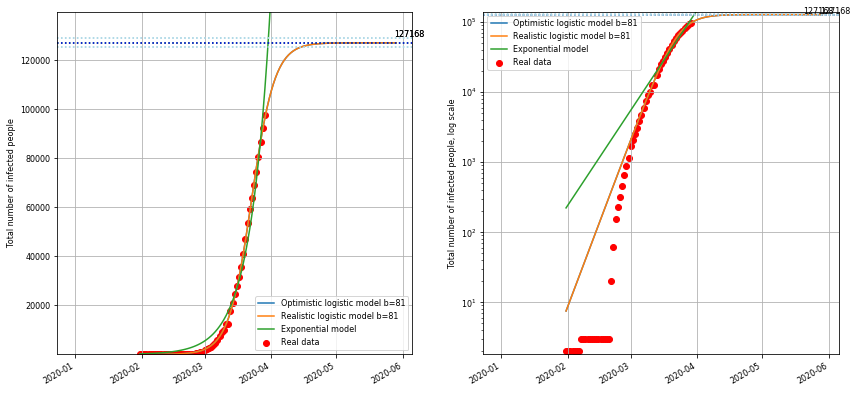

In [16]:
analyze_for_country('Italy',estb=81)

Parameters of logistic model fit a: 5.404030548864576  b: 82.02328453227672  c: 128479.35711215987  errors of c: 2201.8918168558093
Parameters of logistic model fit a: 5.3962671014615085  b: 81.99999999999999  c: 128242.14549786756  errors of c: 2189.427517286385


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


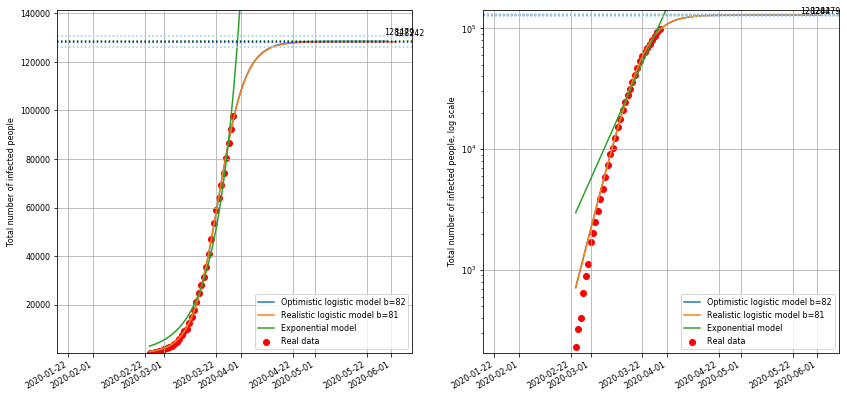

(datetime.datetime(2020, 5, 31, 0, 0),
 (array([5.40403055e+00, 8.20232845e+01, 1.28479357e+05]),
  array([[6.36606786e-03, 1.53294500e-02, 1.56583262e+02],
         [1.53294500e-02, 4.54069117e-02, 4.63000064e+02],
         [1.56583262e+02, 4.63000064e+02, 4.84832757e+06]])),
 [0.07978764224936089, 0.21308897593754106, 2201.8918168558093])

In [17]:
df3=getdatafromItaly()
#dfi
analyze_data(df3,estb=81)

## Shrnutí pro Itálii 
Modely jsou citlivé na vstupní data,[1] a [3]. 
* 13.3. predikce 42393 (+-7887) vs 19293 (+-1111). 
* 16.3. predikce 73519 (+-9427) vs 134252 (+-65720). 

Přidáváme odhad 12 dnů od 9.3.2020 po vyhlášení rozsáhlých karanténních opatřeních v Itálii, tj. b=81 (21. březen +60 dnů leden a únor).
* 16.3. Realistický model predikuje 128639 (+-41596).
* 24.3. Optimistický model odhaduje nyní parametr b=81 ve shodě s realistickým modelem. Predikce 117476(+-5452) nakažených. Parametr a=5.1 jako rychlost šíření infekce ve srovnání s českem (a=2.92) výrazně vyšší.
* 26.3. Oba modely se zhruba shodnou v parametru b=81 (21.3.2020) od té doby počet detekovaných klesá. Predikce 116584(+- 3179) 

# Španělsko


Parameters of logistic model fit a: 4.3511186010505005  b: 86.72709432086828  c: 141294.57709874224  errors of c: 5588.157192031321
Parameters of logistic model fit a: 4.414513988644493  b: 87.00000000000055  c: 145848.95752629836  errors of c: 6125.013710467686


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


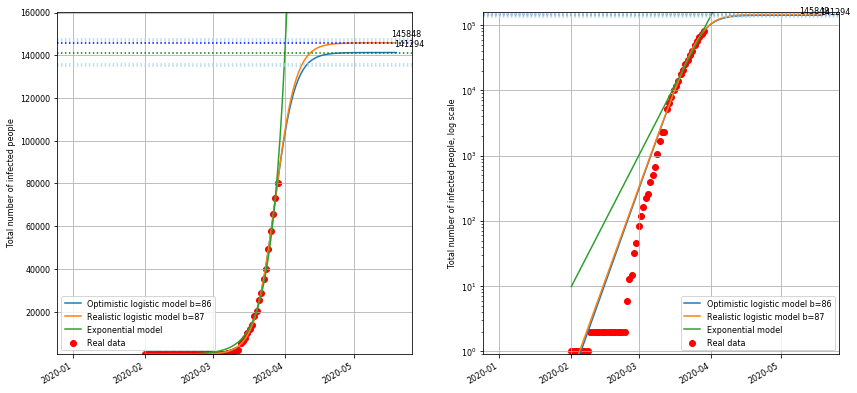

In [18]:
analyze_for_country('Spain',estb=87)

## Shrnutí pro Španělsko
* 24.3. Odhad parametru b pro realistický model na 27. březen(12 dnů po vyhlášení opatřeních dne 15. března, zdroj https://english.elpais.com/politics/2020-03-22/spanish-government-to-extend-state-of-alarm-for-15-days.html?rel=lom). Predikce optimistický 40163(+-1742) vs. realistický 123536(+-62272). Parametr a=3.1 rychlost šíření infekce podobná odhadu hodnoty pro ČR (a=2.92).
* 26.3. Predikce realistického modelu 143316 (+-22303) (optimistický se blíží 123846(+-15606)). Za několik dnů se ukáže, jestli byl parametr b odhadnut dobře nebo se bude epidemie ještě dál šířit nekontrolovaně (exponenciálně).

# Německo

Parameters of logistic model fit a: 4.485209276951125  b: 86.25310700731673  c: 104220.62410433708  errors of c: 5049.451586749265
Parameters of logistic model fit a: 5.060030531768111  b: 89.00000000000016  c: 141338.26182824213  errors of c: 13380.175747666843


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


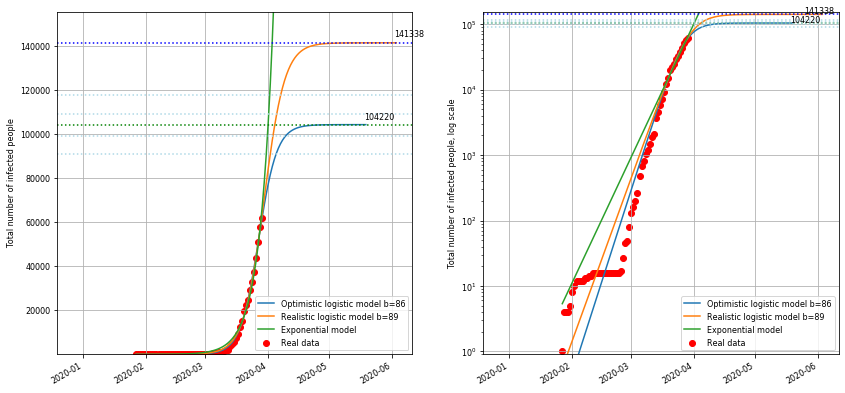

In [19]:
analyze_for_country('Germany',estb=89)

## Shrnutí pro Německo
* 24.3. odhadujeme b na den 29.3.(12 dnů od vyhlášení opatření v Bavorsku a dalších státech, zdroj https://ct24.ceskatelevize.cz/svet/3062960-hranice-schengenskeho-prostoru-se-podle-macrona-uzavrou-v-utery-v-poledne). Predikce 148471 nakažených, zatím s velkou chybou.
* 26.3. predikce 146670 nakažených (+-49047), nicméně není jisté jestli a kdy se dosáhne kritického bodu b, rychlost šíření zatím odpovídá i exponenciálnímu modelu.

# Velká Británie

Parameters of logistic model fit a: 4.5806474661744945  b: 92.04624947021405  c: 67390.86701638014  errors of c: 7875.403818103732
Parameters of logistic model fit a: 4.866806296764667  b: 95.00000000000001  c: 103771.0541168553  errors of c: 22071.158898767655


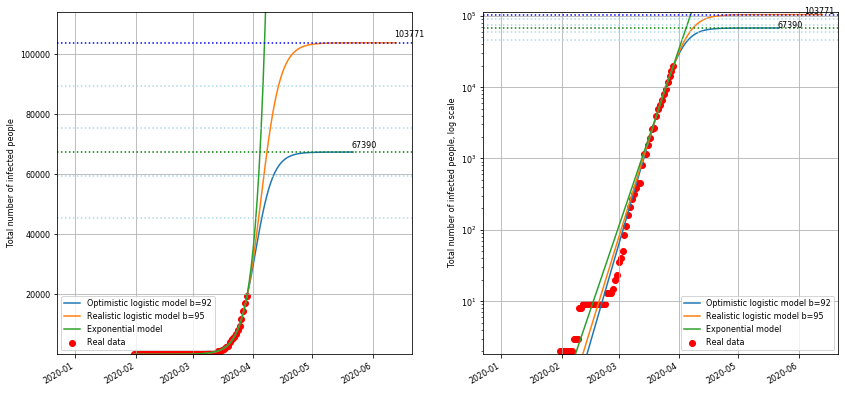

In [20]:
# United Kingdom has more states/provinces in WHO data (Gibraltar, ...), so filtering only UK
analyze_for_country('United Kingdom',estb=95)


## Shrnutí pro Velkou Británii
* 24.3. odhad parametru b=95 (12 dnů od vyhlášení opatření 23.3.). Predikce 95136 zatím velmi nejistá s velkou chybou.  

# Další země

In [21]:
# do analysis for your country, check correct country/region name in data source [3]
#print(dfw[['Country/Region']])
dfw['Country/Region']


0         Afghanistan
1             Albania
2             Algeria
3             Andorra
4              Angola
            ...      
248             Burma
249    United Kingdom
250    United Kingdom
251    United Kingdom
252        MS Zaandam
Name: Country/Region, Length: 253, dtype: object

Parameters of logistic model fit a: 9.999999999999998  b: 110.29676457962273  c: 3238.8063022152587  errors of c: 6965.863568065469
Parameters of logistic model fit a: 6.451088118980428  b: 82.99999999999999  c: 418.7743338478654  errors of c: 76.50587513438141


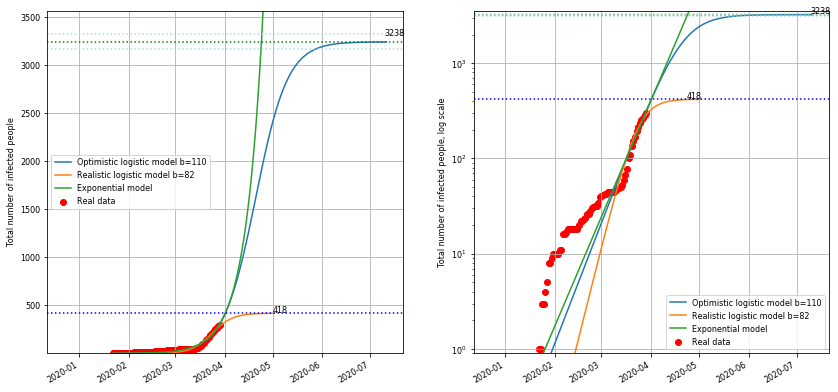

In [22]:
# replace country name 
analyze_for_country('Taiwan*',estb=82)


Parameters of logistic model fit a: 9.999999999999998  b: 99.19477834231793  c: 3429.5626480379788  errors of c: 2089.622065222736


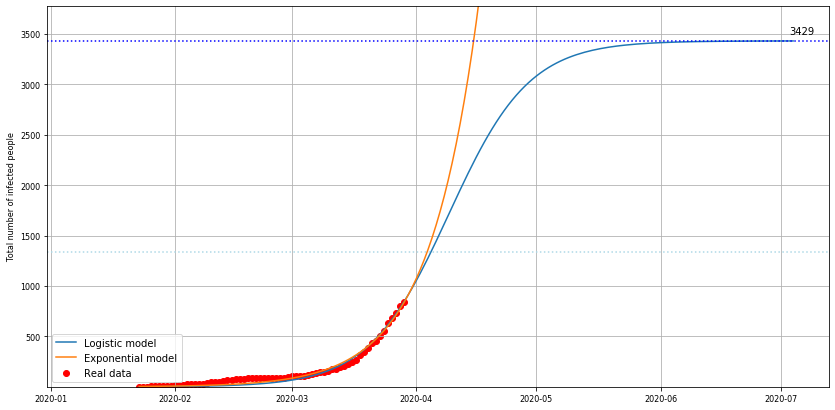

In [23]:
analyze_for_country('Singapore')

Parameters of logistic model fit a: 6.3892576487804345  b: 85.64158321926327  c: 6064.6473044912245  errors of c: 596.5483171673129
Parameters of logistic model fit a: 8.21510265584618  b: 98.00000000000001  c: 16634.033586431746  errors of c: 8259.856086398839


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


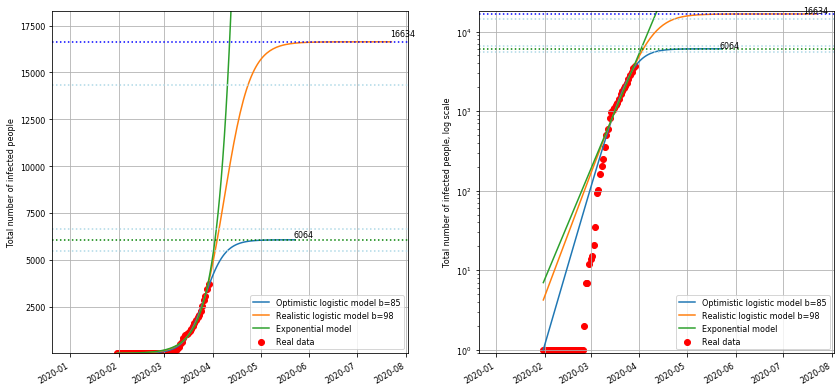

In [24]:
analyze_for_country('Sweden',estb=98)

Parameters of logistic model fit a: 3.7229676517458294  b: 82.2882496846688  c: 17901.24427530794  errors of c: 377.73965509377837


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


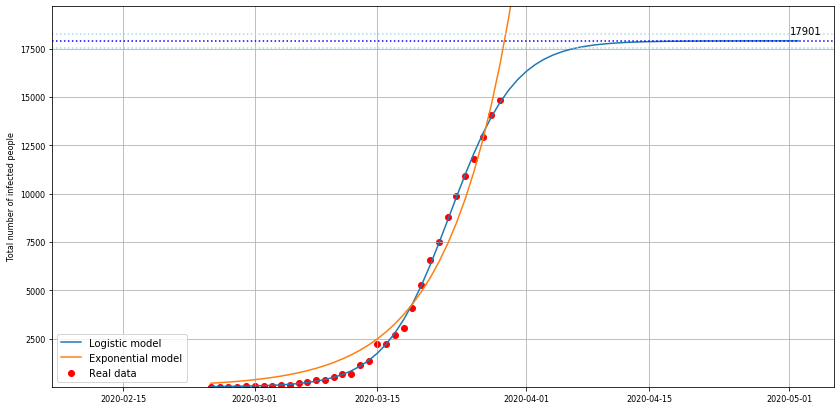

In [25]:
analyze_for_country('Switzerland')

# References
* [1] Gianluca Malato, Covid-19 infection in Italy. Mathematical models and predictions. Data from Italy https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* [2] Komenda M., Karolyi M., Bulhart V., Žofka J., Brauner T., Hak J., Jarkovský J., Mužík J., Blaha M., Kubát J., Klimeš D., Langhammer P., Daňková Š., Májek O., Bartůňková M., Dušek L. COVID-19: Přehled aktuální situace v ČR. Onemocnění aktuálně [online]. Praha: Ministerstvo zdravotnictví ČR, 2020 [cit. 28.03.2020]. Dostupné z: https://onemocneni-aktualne.mzcr.cz/covid-19. Vývoj: společné pracoviště ÚZIS ČR a IBA LF MU. ISSN 2694-9423. 
* [3] World data updated by Johns Hopkins University Center for Systems Science and Engineering https://github.com/CSSEGISandData/COVID-19